#Intro
In this notebook we'll develop a Random Forest for predictive maintenance on FD004 to predict the Remaining Useful Life (RUL) of the engines. FD004 is characterized by the engines developing one of two possible fault modes (see metadata below).

Data Set: FD004 Train trjectories: 248 Test trajectories: 249 Operating conditions: SIX Fault Modes: TWO (HPC Degradation, Fan Degradation)

In [5]:
import seaborn as sns
import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)

import missingno as msno

Pandas version:  2.0.3
Numpy version:  1.24.3


In [6]:
#%pip install missingno

In [7]:
# settings will be used to avoid exponential values in output or tables and to display 50 rows maximum

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

In [25]:
# define filepath and files to read data

train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'

# define column names for easy indexing
index_names = ['unit', 'time']
setting_names = ['op1', 'op2', 'op3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv(('RUL_FD004.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

In [26]:
print(train.shape)
train.head()

(61249, 26)


,unit,time,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,42.005,0.840,100.000,445.000,549.680,1343.430,1112.930,3.910,...,129.780,2387.990,8074.830,9.334,0.020,330,2212,100.000,10.620,6.367
1,1,2,20.002,0.700,100.000,491.190,606.070,1477.610,1237.500,9.350,...,312.590,2387.730,8046.130,9.191,0.020,361,2324,100.000,24.370,14.655
2,1,3,42.004,0.841,100.000,445.000,548.950,1343.120,1117.050,3.910,...,129.620,2387.970,8066.620,9.401,0.020,329,2212,100.000,10.480,6.421
3,1,4,42.000,0.840,100.000,445.000,548.700,1341.240,1118.030,3.910,...,129.800,2388.020,8076.050,9.337,0.020,328,2212,100.000,10.540,6.418
4,1,5,25.006,0.621,60.000,462.540,536.100,1255.230,1033.590,7.050,...,164.110,2028.080,7865.800,10.837,0.020,305,1915,84.930,14.030,8.675


## Calculating RUL

For each time entry, there is a corresponding variable that identifies how many days are left (Remaining Useful Life)

In [27]:
# before we start plotting, let's add RUL
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [28]:
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit,time,RUL
0,1,1,320
1,1,2,319
2,1,3,318
3,1,4,317
4,1,5,316


In [29]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,61249.000,124.325,71.995,1.000,60.000,126.000,185.000,249.000
time,61249.000,134.311,89.783,1.000,62.000,123.000,191.000,543.000
op1,61249.000,24.000,14.781,0.000,10.005,25.001,41.998,42.008
op2,61249.000,0.571,0.311,0.000,0.251,0.700,0.840,0.842
op3,61249.000,94.032,14.252,60.000,100.000,100.000,100.000,100.000
s_1,61249.000,472.882,26.437,445.000,445.000,462.540,491.190,518.670
s_2,61249.000,579.420,37.343,535.480,549.330,555.740,607.070,644.420
s_3,61249.000,1417.897,106.168,1242.670,1350.550,1367.680,1497.420,1613.000
s_4,61249.000,1201.915,119.328,1024.420,1119.490,1136.920,1302.620,1440.770
s_5,61249.000,8.032,3.623,3.910,3.910,7.050,10.520,14.620


In [30]:
# prep data
# drop unwanted columns and split target variable from training set
drop_sensors = []
drop_labels = index_names+setting_names
remaining_sensors = ['s_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [45]:
X_train = train.drop(columns = ['RUL'])
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,61249.000,124.325,71.995,1.000,60.000,126.000,185.000,249.000
time,61249.000,134.311,89.783,1.000,62.000,123.000,191.000,543.000
op1,61249.000,24.000,14.781,0.000,10.005,25.001,41.998,42.008
op2,61249.000,0.571,0.311,0.000,0.251,0.700,0.840,0.842
op3,61249.000,94.032,14.252,60.000,100.000,100.000,100.000,100.000
s_1,61249.000,472.882,26.437,445.000,445.000,462.540,491.190,518.670
s_2,61249.000,579.420,37.343,535.480,549.330,555.740,607.070,644.420
s_3,61249.000,1417.897,106.168,1242.670,1350.550,1367.680,1497.420,1613.000
s_4,61249.000,1201.915,119.328,1024.420,1119.490,1136.920,1302.620,1440.770
s_5,61249.000,8.032,3.623,3.910,3.910,7.050,10.520,14.620


In [47]:
y_train = train['RUL']
y_train_clipped = y_train.clip(upper=125)  # apply RUL clipping from earlier posts

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit').last().reset_index().drop(drop_labels, axis=1)
df_max_rul = train[['unit', 'RUL']].groupby('unit').first().reset_index()

# Consider the distribution of RUL
We can see clearly that it is right skewed.

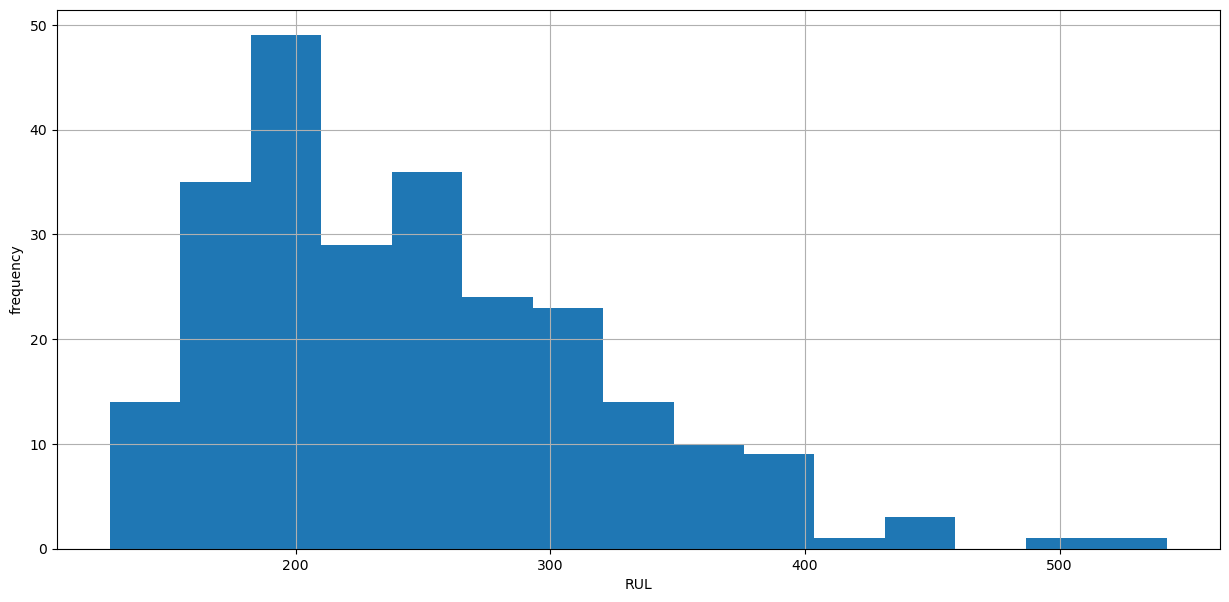

In [48]:
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel("RUL")
plt.ylabel("frequency")
plt.show()

# Perform Modeling

In [49]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
X_test = test.groupby('unit').last().reset_index()

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

In [51]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:20.882917917539096, R2:0.7362785194818396
test set RMSE:34.77423798457117, R2:0.5932354282071105


## Our Linear Regression baseline is 59% on the test set. Lets see how we can improve. 

In [52]:
X_test

,unit,time,op1,op2,op3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,230,25.007,0.621,60.000,462.540,537.660,1264.310,1046.410,7.050,...,166.190,2028.530,7890.310,10.761,0.020,308,1915,84.930,14.410,8.633
1,2,153,41.999,0.840,100.000,445.000,549.960,1354.050,1133.550,3.910,...,130.170,2387.720,8073.440,9.393,0.020,331,2212,100.000,10.580,6.433
2,3,141,42.001,0.840,100.000,445.000,549.470,1341.060,1118.900,3.910,...,130.730,2388.180,8095.580,9.297,0.020,330,2212,100.000,10.610,6.349
3,4,208,25.002,0.621,60.000,462.540,536.060,1253.490,1038.530,7.050,...,164.910,2028.300,7878.630,10.840,0.020,306,1915,84.930,14.410,8.570
4,5,51,25.004,0.620,60.000,462.540,537.360,1263.600,1052.520,7.050,...,164.950,2028.240,7873.750,10.909,0.020,307,1915,84.930,14.190,8.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,244,184,20.004,0.700,100.000,491.190,607.940,1488.250,1255.520,9.350,...,314.850,2388.390,8094.020,9.256,0.020,364,2324,100.000,24.420,14.526
244,245,63,20.007,0.702,100.000,491.190,606.610,1481.480,1238.300,9.350,...,315.990,2388.030,8066.790,9.142,0.020,363,2324,100.000,24.700,14.836
245,246,29,19.998,0.701,100.000,491.190,606.820,1483.010,1241.320,9.350,...,315.220,2388.020,8060.860,9.177,0.020,364,2324,100.000,24.700,14.737
246,247,94,25.002,0.622,60.000,462.540,536.910,1261.670,1052.330,7.050,...,164.600,2028.240,7878.480,10.933,0.020,307,1915,84.930,14.210,8.472


In [53]:
import statsmodels.api as sm

In [54]:
X = X_train

X_with_const = sm.add_constant(X)

model = sm.OLS(y_train, X_with_const)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     3898.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:23:58   Log-Likelihood:            -3.3320e+05
No. Observations:               61249   AIC:                         6.665e+05
Df Residuals:                   61223   BIC:                         6.667e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7681      3.824      1.508      0.131      -1.728      13.264
unit          -0.0133      0.003     -4.227      0.000      -0.019      -0.007
time          -0.3786      0.004   -101.465      0.000      -0.386      -0.371
op1          -48.2983     32.333     -1.494      0.135    -111.671      15.074
op2          -15.2417    323.670     -0.047      0.962    -649.637     619.153
op3         1078.8729    636.683      1.695      0.090    -169.027    2326.773
s_1          403.5127    230.359      1.752      0.080     -47.992     855.017
s_2           -9.9085      0.713    -13.906      0.000     -11.305      -8.512
s_3           -0.8114      0.054    -14.964      0.000      -0.918      -0.705
s_4           -1.3323      0.050    -26.562      0.000      -1.431      -1.234
s_5         -173.7096    137.341     -1.265      0.206    -442.899      95.480
s_6          -46.3051     21.987     -2.106      0.035     -89.399      -3.211
s_7            0.1284      0.453      0.283      0.777      -0.760       1.017
s_8           -5.0714      5.523     -0.918      0.358     -15.896       5.753
s_9           -0.3725      0.044     -8.374      0.000      -0.460      -0.285
s_10         -51.9696     68.868     -0.755      0.450    -186.951      83.012
s_11         -72.4053      1.789    -40.470      0.000     -75.912     -68.899
s_12          -1.2680      0.494     -2.567      0.010      -2.236      -0.300
s_13          -3.5136      5.217     -0.674      0.501     -13.738       6.711
s_14           0.2968      0.050      5.933      0.000       0.199       0.395
s_15         -76.7453      7.065    -10.863      0.000     -90.592     -62.898
s_16         826.3368    166.660      4.958      0.000     499.683    1152.991
s_17          -4.0488      0.227    -17.818      0.000      -4.494      -3.603
s_18        -148.0346     94.626     -1.564      0.118    -333.503      37.433
s_19         765.9643    460.403      1.664      0.096    -136.427    1668.356
s_20           9.7798      2.148      4.552      0.000       5.569      13.991
s_21          15.5454      3.585      4.336      0.000       8.518      22.573
==============================================================================
Omnibus:                     9530.614   Durbin-Watson:                   0.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19700.137
Skew:                           0.944   Prob(JB):                         0.00
Kurtosis:                       5.039   Cond. No.                     1.33e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.49e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is 

### We have several variables with a p-value > 0.05. It may benefit the model and improve adjusted R^2 if we removed them

In [55]:


X_with_const = sm.add_constant(X)

model = sm.OLS(y_train, X_with_const)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     3898.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:39:53   Log-Likelihood:            -3.3320e+05
No. Observations:               61249   AIC:                         6.665e+05
Df Residuals:                   61223   BIC:                         6.667e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7681      3.824      1.508      0.131      -1.728      13.264
unit          -0.0133      0.003     -4.227      0.000      -0.019      -0.007
time          -0.3786      0.004   -101.465      0.000      -0.386      -0.371
op1          -48.2983     32.333     -1.494      0.135    -111.671      15.074
op2          -15.2417    323.670     -0.047      0.962    -649.637     619.153
op3         1078.8729    636.683      1.695      0.090    -169.027    2326.773
s_1          403.5127    230.359      1.752      0.080     -47.992     855.017
s_2           -9.9085      0.713    -13.906      0.000     -11.305      -8.512
s_3           -0.8114      0.054    -14.964      0.000      -0.918      -0.705
s_4           -1.3323      0.050    -26.562      0.000      -1.431      -1.234
s_5         -173.7096    137.341     -1.265      0.206    -442.899      95.480
s_6          -46.3051     21.987     -2.106      0.035     -89.399      -3.211
s_7            0.1284      0.453      0.283      0.777      -0.760       1.017
s_8           -5.0714      5.523     -0.918      0.358     -15.896       5.753
s_9           -0.3725      0.044     -8.374      0.000      -0.460      -0.285
s_10         -51.9696     68.868     -0.755      0.450    -186.951      83.012
s_11         -72.4053      1.789    -40.470      0.000     -75.912     -68.899
s_12          -1.2680      0.494     -2.567      0.010      -2.236      -0.300
s_13          -3.5136      5.217     -0.674      0.501     -13.738       6.711
s_14           0.2968      0.050      5.933      0.000       0.199       0.395
s_15         -76.7453      7.065    -10.863      0.000     -90.592     -62.898
s_16         826.3368    166.660      4.958      0.000     499.683    1152.991
s_17          -4.0488      0.227    -17.818      0.000      -4.494      -3.603
s_18        -148.0346     94.626     -1.564      0.118    -333.503      37.433
s_19         765.9643    460.403      1.664      0.096    -136.427    1668.356
s_20           9.7798      2.148      4.552      0.000       5.569      13.991
s_21          15.5454      3.585      4.336      0.000       8.518      22.573
==============================================================================
Omnibus:                     9530.614   Durbin-Watson:                   0.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19700.137
Skew:                           0.944   Prob(JB):                         0.00
Kurtosis:                       5.039   Cond. No.                     1.33e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.49e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is 

In [ ]:
X

### Notes state there may be strong multicollinearity problems, so lets look at a correlation matrix

In [56]:
corr_test = X_with_const.join(y_test)

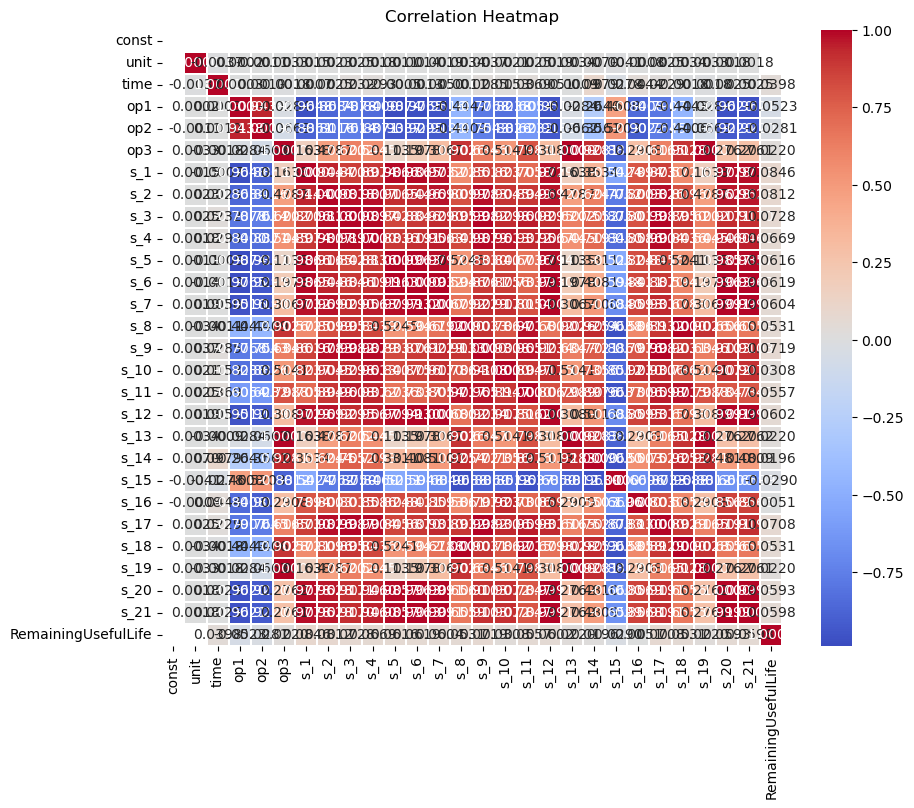

In [57]:
corr_matrix = corr_test.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=.1)

# Add labels and title
plt.title('Correlation Heatmap')
plt.show()

### It seems we need to remove several with over 70% correlation. 

In [58]:
y_test

,RemainingUsefulLife
0,22
1,39
2,107
3,75
4,149
...,...
243,35
244,131
245,194
246,112


In [60]:
drop = ['s_2','s_5', 's_6', 's_7', 's_12','s_20', 's_21']
X = X.drop(columns = drop)

X_with_const = sm.add_constant(X)


model = sm.OLS(y_train, X_with_const)
results = model.fit()

results.summary()
                      
                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     5377.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:42:53   Log-Likelihood:            -3.3334e+05
No. Observations:               61249   AIC:                         6.667e+05
Df Residuals:                   61230   BIC:                         6.669e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3029      1.973      0.154      0.878      -3.564       4.169
unit          -0.0130      0.003     -4.156      0.000      -0.019      -0.007
time          -0.3765      0.003   -113.858      0.000      -0.383      -0.370
op1            8.6480      0.225     38.360      0.000       8.206       9.090
op2         -583.9814     24.467    -23.868      0.000    -631.937    -536.026
op3         -106.7783     12.260     -8.709      0.000    -130.809     -82.748
s_1          -30.4996      4.190     -7.279      0.000     -38.712     -22.287
s_3           -0.9024      0.054    -16.733      0.000      -1.008      -0.797
s_4           -1.4790      0.049    -29.951      0.000      -1.576      -1.382
s_8           -7.5729      5.517     -1.373      0.170     -18.387       3.241
s_9           -0.4254      0.044     -9.619      0.000      -0.512      -0.339
s_10           7.7419     67.821      0.114      0.909    -125.188     140.672
s_11         -79.7054      1.719    -46.365      0.000     -83.075     -76.336
s_13          -4.1232      5.210     -0.791      0.429     -14.335       6.088
s_14           0.3541      0.050      7.087      0.000       0.256       0.452
s_15         -99.7581      5.452    -18.298      0.000    -110.444     -89.072
s_16         751.7877    166.803      4.507      0.000     424.854    1078.722
s_17          -4.4497      0.226    -19.712      0.000      -4.892      -4.007
s_18          28.2938      5.233      5.407      0.000      18.037      38.551
s_19         -21.3517    122.024     -0.175      0.861    -260.519     217.815
==============================================================================
Omnibus:                     9514.483   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19633.608
Skew:                           0.943   Prob(JB):                         0.00
Kurtosis:                       5.034   Cond. No.                     3.35e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.57e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### There has been minute notable improvement of R^2 using OLS modeling. We will keep the reduced dataset and move to other model types

In [61]:
from sklearn.preprocessing import StandardScaler

# create scaler object
scaler = StandardScaler()

# fit scaler to our dataset (find mean, std
scaler.fit(X)

# apply z-score transformation
X1 = scaler.transform(X)

X1 = pd.DataFrame(X1, columns=X.columns)

In [62]:
X1_with_const = sm.add_constant(X1)

model = sm.OLS(y_train, X1_with_const)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RUL   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     5377.
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:43:14   Log-Likelihood:            -3.3334e+05
No. Observations:               61249   AIC:                         6.667e+05
Df Residuals:                   61230   BIC:                         6.669e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.3114      0.226    590.219      0.000     132.869     133.754
unit          -0.9393      0.226     -4.156      0.000      -1.382      -0.496
time         -33.8007      0.297   -113.858      0.000     -34.383     -33.219
op1          127.8230      3.332     38.360      0.000     121.292     134.354
op2         -181.4435      7.602    -23.868      0.000    -196.343    -166.544
op3         -818.2166    323.281     -2.531      0.011   -1451.849    -184.584
s_1         -806.3050    110.774     -7.279      0.000   -1023.423    -589.187
s_3          -95.8003      5.725    -16.733      0.000    -107.022     -84.579
s_4         -176.4863      5.892    -29.951      0.000    -188.035    -164.937
s_8        -1100.6934    801.906     -1.373      0.170   -2672.431     471.045
s_9         -143.3258     14.901     -9.619      0.000    -172.531    -114.120
s_10           0.9885      8.659      0.114      0.909     -15.984      17.961
s_11        -258.5216      5.576    -46.365      0.000    -269.450    -247.593
s_13        -528.5774    667.893     -0.791      0.429   -1837.650     780.495
s_14          30.3386      4.281      7.087      0.000      21.948      38.730
s_15         -74.8552      4.091    -18.298      0.000     -82.873     -66.837
s_16           3.5219      0.781      4.507      0.000       1.990       5.053
s_17        -123.7388      6.277    -19.712      0.000    -136.042    -111.435
s_18        4115.9379    761.281      5.407      0.000    2623.824    5608.052
s_19        -818.2166    323.281     -2.531      0.011   -1451.849    -184.584
==============================================================================
Omnibus:                     9514.483   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19633.608
Skew:                           0.943   Prob(JB):                         0.00
Kurtosis:                       5.034   Cond. No.                     1.87e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.26e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### R^2 also showing no significant improvement. 

In [63]:
X_train = X_train.drop (columns = drop)

X_train

,unit,time,op1,op2,op3,s_1,s_3,s_4,s_8,s_9,s_10,s_11,s_13,s_14,s_15,s_16,s_17,s_18,s_19
0,1,1,42.005,0.840,100.000,445.000,1343.430,1112.930,2211.860,8311.320,1.010,41.690,2387.990,8074.830,9.334,0.020,330,2212,100.000
1,1,2,20.002,0.700,100.000,491.190,1477.610,1237.500,2323.660,8713.600,1.070,43.940,2387.730,8046.130,9.191,0.020,361,2324,100.000
2,1,3,42.004,0.841,100.000,445.000,1343.120,1117.050,2211.920,8306.690,1.010,41.660,2387.970,8066.620,9.401,0.020,329,2212,100.000
3,1,4,42.000,0.840,100.000,445.000,1341.240,1118.030,2211.880,8312.350,1.020,41.680,2388.020,8076.050,9.337,0.020,328,2212,100.000
4,1,5,25.006,0.621,60.000,462.540,1255.230,1033.590,1915.220,7994.940,0.930,36.480,2028.080,7865.800,10.837,0.020,305,1915,84.930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,10.000,0.250,100.000,489.050,1516.360,1315.280,2319.660,8840.160,1.270,46.080,2388.730,8185.690,8.454,0.030,372,2319,100.000
61245,249,252,0.003,0.002,100.000,518.670,1598.920,1426.770,2388.470,9117.120,1.310,48.040,2388.460,8185.470,8.222,0.030,396,2388,100.000
61246,249,253,0.003,0.000,100.000,518.670,1607.720,1430.560,2388.510,9126.530,1.310,48.240,2388.480,8193.940,8.252,0.030,395,2388,100.000
61247,249,254,35.005,0.840,100.000,449.440,1381.290,1148.180,2223.780,8403.640,1.050,42.530,2388.830,8125.640,9.052,0.020,337,2223,100.000


In [64]:
X_test = X_test.drop (columns = drop)
X_test

,unit,time,op1,op2,op3,s_1,s_3,s_4,s_8,s_9,s_10,s_11,s_13,s_14,s_15,s_16,s_17,s_18,s_19
0,1,230,25.007,0.621,60.000,462.540,1264.310,1046.410,1915.660,8023.100,0.940,36.870,2028.530,7890.310,10.761,0.020,308,1915,84.930
1,2,153,41.999,0.840,100.000,445.000,1354.050,1133.550,2211.690,8310.360,1.020,42.290,2387.720,8073.440,9.393,0.020,331,2212,100.000
2,3,141,42.001,0.840,100.000,445.000,1341.060,1118.900,2212.040,8331.130,1.020,41.820,2388.180,8095.580,9.297,0.020,330,2212,100.000
3,4,208,25.002,0.621,60.000,462.540,1253.490,1038.530,1915.390,8012.460,0.940,36.570,2028.300,7878.630,10.840,0.020,306,1915,84.930
4,5,51,25.004,0.620,60.000,462.540,1263.600,1052.520,1915.360,8011.760,0.940,37.110,2028.240,7873.750,10.909,0.020,307,1915,84.930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,244,184,20.004,0.700,100.000,491.190,1488.250,1255.520,2324.210,8761.890,1.080,44.680,2388.390,8094.020,9.256,0.020,364,2324,100.000
244,245,63,20.007,0.702,100.000,491.190,1481.480,1238.300,2323.930,8726.740,1.080,44.240,2388.030,8066.790,9.142,0.020,363,2324,100.000
245,246,29,19.998,0.701,100.000,491.190,1483.010,1241.320,2323.900,8722.260,1.080,44.010,2388.020,8060.860,9.177,0.020,364,2324,100.000
246,247,94,25.002,0.622,60.000,462.540,1261.670,1052.330,1915.310,8006.630,0.940,37.000,2028.240,7878.480,10.933,0.020,307,1915,84.930


In [65]:
y_train_clipped

0        125
1        125
2        125
3        125
4        125
        ... 
61244      4
61245      3
61246      2
61247      1
61248      0
Name: RUL, Length: 61249, dtype: int64

# Train/test Split
Since the Data provided the Test/Train Split, we have split according to the provided datasets

In [66]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(X_train, y_train_clipped)

y_train_pred_lin = model1.predict(X_train)
y_test_pred_lin  = model1.predict(X_test)

In [67]:
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_lin)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_lin)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train, y_train_pred_lin)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_lin)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.7140218490008776
r^2 (test):   0.5653084319718937

MSE (train):  6096.292867856732
MSE (test):   1292.2702313408856

RMSE (train): 78.07876067059935
RMSE (test):  35.94816033319209



## Linear Regression with the reduced features actually has a lower r^2 on the test set.

# KNeighbors Regressor

In [68]:
from sklearn.neighbors import KNeighborsRegressor

nNeigh = 5

#model2 = KNeighborsRegressor(n_neighbors=nNeigh)
model2 = KNeighborsRegressor(n_neighbors=nNeigh,weights='uniform')
#model2 = KNeighborsRegressor(n_neighbors=nNeigh,weights='distance')

model2.fit(X_train, y_train_clipped)

y_train_pred_knn = model2.predict(X_train)
y_test_pred_knn  = model2.predict(X_test)

In [69]:
# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_knn)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_knn)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train, y_train_pred_knn)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_knn)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.9030652426840514
r^2 (test):   0.5699664258936766

MSE (train):  5840.494151414717
MSE (test):   1278.4227419354838

RMSE (train): 76.42312576317929
RMSE (test):  35.75503799376367



# Decision Tree Regressor

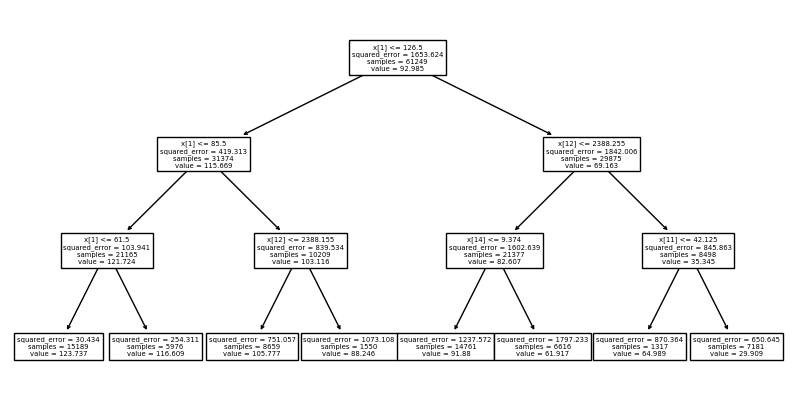

In [70]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

model3 = DecisionTreeRegressor(max_depth=3)
#model3 = DecisionTreeRegressor(min_samples_split=3)
#model3 = DecisionTreeRegressor()
model3.fit(X_train, y_train_clipped)

y_train_pred_tree = model3.predict(X_train)
y_test_pred_tree  = model3.predict(X_test)

plt.figure(figsize=(10,5))
#plot_tree(model3, rounded=True, fontsize=10);
plot_tree(model3);

In [71]:
# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_tree)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_tree)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train, y_train_pred_tree)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_tree)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.5445863010202763
r^2 (test):   0.40360291472798826

MSE (train):  7083.937562261285
MSE (test):   1772.9955123161265

RMSE (train): 84.16613073119903
RMSE (test):  42.106953253781334



# Random Forest Regressor

In [72]:
from sklearn.ensemble import RandomForestRegressor

model4 = RandomForestRegressor()
#model4 = RandomForestRegressor(n_estimators=100, max_depth=3)
#model4 = RandomForestRegressor(n_estimators=100, min_samples_split=3)
model4.fit(X_train, y_train_clipped)

y_train_pred_forest = model4.predict(X_train)
y_test_pred_forest = model4.predict(X_test)


In [73]:
# r^2
r2_train = r2_score(y_train_clipped, y_train_pred_forest)
print(f'r^2 (train):  {r2_train}')

r2_test = r2_score(y_test, y_test_pred_forest)
print(f'r^2 (test):   {r2_test}')
print()

# MSE
mse_train = mean_squared_error(y_train_clipped, y_train_pred_forest)
print(f'MSE (train):  {mse_train}')

mse_test = mean_squared_error(y_test, y_test_pred_forest)
print(f'MSE (test):   {mse_test}')
print()

# RMSE
rmse_train = sqrt(mse_train)
print(f'RMSE (train): {rmse_train}')

rmse_test = sqrt(mse_test)
print(f'RMSE (test):  {rmse_test}')
print()

r^2 (train):  0.9813342293454581
r^2 (test):   0.7002926438543738

MSE (train):  30.866172791392508
MSE (test):   890.9832233870968

RMSE (train): 5.555733326158888
RMSE (test):  29.8493420930361



# Random Forest Seems to come out on top so far with a test r^2 of 70% which is much improved from the others we have seen.


In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

models = [LinearRegression(), 
          KNeighborsRegressor( n_neighbors=2, weights='uniform' ),
          KNeighborsRegressor( n_neighbors=6, weights='uniform' ),
          KNeighborsRegressor( n_neighbors=25, weights='uniform' ),
          DecisionTreeRegressor(max_depth=3 ),
          DecisionTreeRegressor(max_depth=10 ),
          RandomForestRegressor( n_estimators =100, max_depth =3),
          RandomForestRegressor( n_estimators =100, max_depth =10),
          RandomForestRegressor(n_estimators=100, min_samples_split=3),
          GradientBoostingRegressor( n_estimators =100, learning_rate = 0.1, max_depth=3),
          GradientBoostingRegressor( n_estimators =100, learning_rate = 0.1, max_depth=4),
          GradientBoostingRegressor( n_estimators =100, learning_rate = 0.1, max_depth=5),
          GradientBoostingRegressor( n_estimators =100, learning_rate = 0.1, max_depth=6),         
         ]
          
          

In [75]:
for m in models:
    m.fit(X_train, y_train_clipped)
    
    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)
    
    print(m)
    
    r2_train = r2_score( y_train_clipped, y_train_pred)
    print(f'r^2 (train): {r2_train}')
    
    r2_test = r2_score( y_test, y_test_pred)
    print(f'r^2 (test): {r2_test}')
    print()
#end

LinearRegression()
r^2 (train): 0.7140218490008776
r^2 (test): 0.5653084319718937

KNeighborsRegressor(n_neighbors=2)
r^2 (train): 0.9461461252376928
r^2 (test): 0.5482630314745481

KNeighborsRegressor(n_neighbors=6)
r^2 (train): 0.8946037145349298
r^2 (test): 0.5661516993836964

KNeighborsRegressor(n_neighbors=25)
r^2 (train): 0.8152693570488203
r^2 (test): 0.5283606993956562

DecisionTreeRegressor(max_depth=3)
r^2 (train): 0.5445863010202763
r^2 (test): 0.40360291472798826

DecisionTreeRegressor(max_depth=10)
r^2 (train): 0.8251015163712576
r^2 (test): 0.6796620135539777

RandomForestRegressor(max_depth=3)
r^2 (train): 0.5567598264147894
r^2 (test): 0.4139606387106043

RandomForestRegressor(max_depth=10)
r^2 (train): 0.857638855574157
r^2 (test): 0.6837246041919147

RandomForestRegressor(min_samples_split=3)
r^2 (train): 0.9796834848629219
r^2 (test): 0.7026160444368039

GradientBoostingRegressor()
r^2 (train): 0.808157929154185
r^2 (test): 0.6425567236298149

GradientBoostingRegress

## Random Forest is the best out of all of our tests. But 70% is not ideal. 

In [76]:
m =RandomForestRegressor(n_estimators=100, min_samples_split=3).fit(X_train, y_train_clipped)
    
y_train_pred = m.predict(X_train)
y_test_pred = m.predict(X_test)

In [77]:
# Ensure both arrays have the same length
assert len(y_test) == len(y_test_pred)

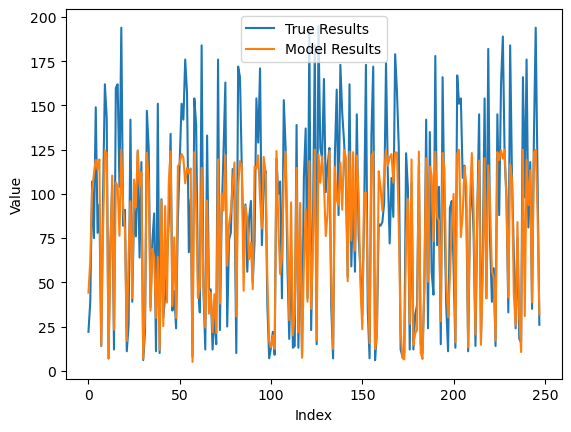

In [78]:
true_results = y_test
model_results = y_test_pred


# Plot the results
plt.plot(true_results, label='True Results')
plt.plot(model_results, label='Model Results')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# What this means in the context of this problem. 

For all values under 125 our model easily predicteds with high accuracy. The model does not seem built to go over this threshold. I plan to revisit the code to make sure there weren't any errors. 

But, even so, we underpredicted and in 